In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [200]:
class Circuit:
    def __init__(self,n):
        self.n = n
        self.wires = [Wire(k) for k in range(n)]
        self.gates = []
        
    def addGate(self,g):
        self.gates.append(g)
        for bit in g.bits:
            self.wires[bit].addGate(g)
    
    def __str__(self):
        string = ""
        for gate in self.gates:
            string = string + str(gate)
            
        return string
        
    def fullStoch(self):
        stoch = None
        for gate in self.gates:
            if stoch is None:
                stoch = gate.fullStoch(self.n)
            else:
                stoch = np.dot(gate.fullStoch(self.n), stoch)
        return stoch
    
    
    def printWires(self):
        for wire in self.wires:
            print(wire)
            
    def fireShot(self):
        state = np.array([np.random.randint(0,high=2) for i in range(self.n)])
        for gate in self.gates:
            gate_state = [state[b] for b in gate.bits]
            gate_state = gate.fireLocal(gate_state)
            for i in range(len(gate_state)):
                state[gate.bits[i]] = gate_state[i]
        return state
        
    def expectationShots(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        runningtotal = self.fireShot()
        for i in range(numshots-1):
            runningtotal = runningtotal + self.fireShot()
        
        return [x / numshots for x in runningtotal]
    
    def shotsHistogram(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = np.zeros(2**self.n)
        xs = np.zeros(2**self.n)
        
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                 ind += 2**k * state[k] 
            histstates[ind] += 1
            xs[ind] = ind
        print(histstates)
        print(histstates.shape)
        hist = plt.bar(xs,histstates)
        return hist
        
class Wire:
    def __init__(self,k):
        self.k = k
        self.gates = []
    
    def addGate(self,g):
        self.gates.append(g)
    
    def removeLastGate(self):
        return self.gates.pop()
    
    def __str__(self):
        string = f"[{self.k}]:"
        for gate in self.gates:
            string += str(gate)
        return string

class Gate:
    #assumes if bits = (0,1,2), order is kron(b2,b1,b0).  This follows from c01 gate having control
    #on 0 and target on 1 by convention
    gatecount = 0

    def __init__(self,matrix,bits):
        assert(matrix.shape == (2**len(bits),2**len(bits)))
        self.matrix = matrix
        self.bits = bits
        self.id = Gate.gatecount
        Gate.gatecount += 1
        
    def __str__(self):
        return f"-g{self.id}-"
    
    
    def fireLocal(self,state):
        #TODO: verify that this is resilient to weird ordered qubits
        state_dist = state2dist(len(state),state)
        new_dist = np.dot(self.matrix,state_dist);
        new_state = sampledist(len(state),new_dist)
        return new_state;
    
    def fullStoch(self,n):
        #TODO: optimize for adjacent bit states (no swaps required)
        #first construct hamiltonian operating on first len(bits) qubits, then swap bits to fit order
        stoch = self.matrix
        for i in range(n - len(self.bits)):
            stoch = np.kron([[1,0],[0,1]],stoch)
            
        swaps = Gate._swapcircuit(self,n)
        if len(swaps):
            stoch = np.dot(stoch, np.transpose(swaps))
            stoch = np.dot(swaps, stoch)
            
        return stoch
    
    def _swapcircuit(self,n):
        swaplist = Gate._bubbleSortOperations(self.bits) 
        sortedbits = sorted(self.bits)
        for i in range(len(sortedbits)-1,-1,-1):
            if not (i == sortedbits[i]):
                swaplist.append((i,sortedbits[i]))
        return Gate._swapStoch(self,n,swaplist)
    
    
    def _swapStoch(self,n,swaplist):
        swapMatrix =  []
        if not (len(swaplist) == 0):
            swapMatrix = np.eye(2**n)
            for swapbits in swaplist:
                swapMatrix = np.dot(Gate._generateSwapMatrix(n,swapbits),swapMatrix)
        return swapMatrix
    
    def _generateSwapMatrix(n,swapbits):
        N = 2**n
        swapMat = np.zeros((N,N))
        for i in range(N):
            mask1 = i >> swapbits[0] & 1
            mask2 = i >> swapbits[1] & 1
            xor = mask1 ^ mask2
            xor = xor << swapbits[0] | xor << swapbits[1]
            j = i ^ xor
            swapMat[i,j] = 1
        return swapMat
    
    def _bubbleSortOperations(bits):
        issorted = False
        swaplist = []
        while not issorted:
            issorted = True
            for i in range(len(bits) - 1):
                if bits[i] > bits[i+1]:
                    temp = bits[i]
                    bits[i] = bits[i+1]
                    bits[i+1] = temp
                    issorted = False
                    swaplist.append((i,i+1))
        return swaplist

def state2dist(n,state):
    ##reverse marginal calculation, assuming no correlation
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #simialr to a bit string
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    dist = np.zeros(2**n)
    for i in range(2**n):
        iprob = 1;
        for k in range(n):
            if (1 << k) & i:
                iprob *= state[k]
            else:
                iprob *= 1.0 - state[k]
        dist[i] = iprob
    return dist
            
        
def dist2state(n,dist):
    ##Effectively a marginal calculation
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #similar to a bit string
    outstate = np.zeros(n);
    for i in range(2**n):
        for k in range(n):
            outstate[k] += (((1 << k) & i)>>k) * dist[i]
            
    return outstate
            
def sampledist(n,dist):
    choices = [i for i in range(2**n)]
    choice = np.random.choice(choices,p=dist)
    state = np.zeros(n)
    for i in range(n):
        state[i] += (((1 << i) & choice) >> i)
    return state
    


In [201]:
(np.zeros(2)).shape

(2,)

In [202]:
swaptemp(3,(2,1))

NameError: name 'swaptemp' is not defined

In [203]:
circ = Circuit(3)

In [204]:
C10 = Gate(np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]),(1,2))

In [205]:
C10.matrix

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [206]:
circ.addGate(C10)

In [207]:
print(str(circ))
circ.printWires()

-g0-
[0]:
[1]:-g0-
[2]:-g0-


In [208]:
stoch = circ.fullStoch()
for i in range(8):
    x = np.zeros((8,1))
    x[i] = 1
    a,b = np.where(np.dot(stoch,x) == 1)
    print(i , " => " , a[0])
    
print(stoch)
    

0  =>  0
1  =>  1
2  =>  2
3  =>  3
4  =>  6
5  =>  7
6  =>  4
7  =>  5
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [209]:
np.transpose([1j])

array([0.+1.j])

In [210]:
a = np.array([1,2])
b = np.array([2,4])
a + b

array([3, 6])

In [211]:
#circ.expectationShots(100000)

In [212]:
x = np.array([[0,1],[1,0]])
np.dot(x,x)

array([[1, 0],
       [0, 1]])

In [213]:
def test_swap_alg(targs,n):
    targs = np.array(targs)
    tmpls = [i for i in range(n)]
    end = np.setdiff1d(tmpls,targs)
    ls = np.concatenate((targs,end))
    return ls

In [214]:
print(test_swap_alg([3,1], 5))

[3 1 0 2 4]


In [215]:
targs = [1, 3,4]
ls = [i for i in range(10)]

ls[targs in ls]

0

[122. 136. 112. 106. 128. 125. 124. 147.]
(8,)


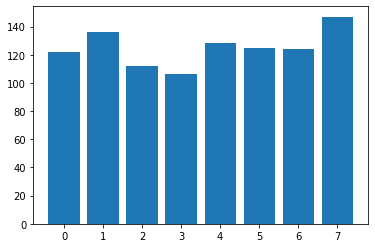

In [216]:
hist = circ.shotsHistogram(1000)

In [217]:
np.zeros((2,2))

array([[0., 0.],
       [0., 0.]])

In [53]:
x = np.array([[0, 1],[1,0]])
I = np.array([[1, 0],[0,1]])
np.dot(x,I)

array([[0, 1],
       [1, 0]])